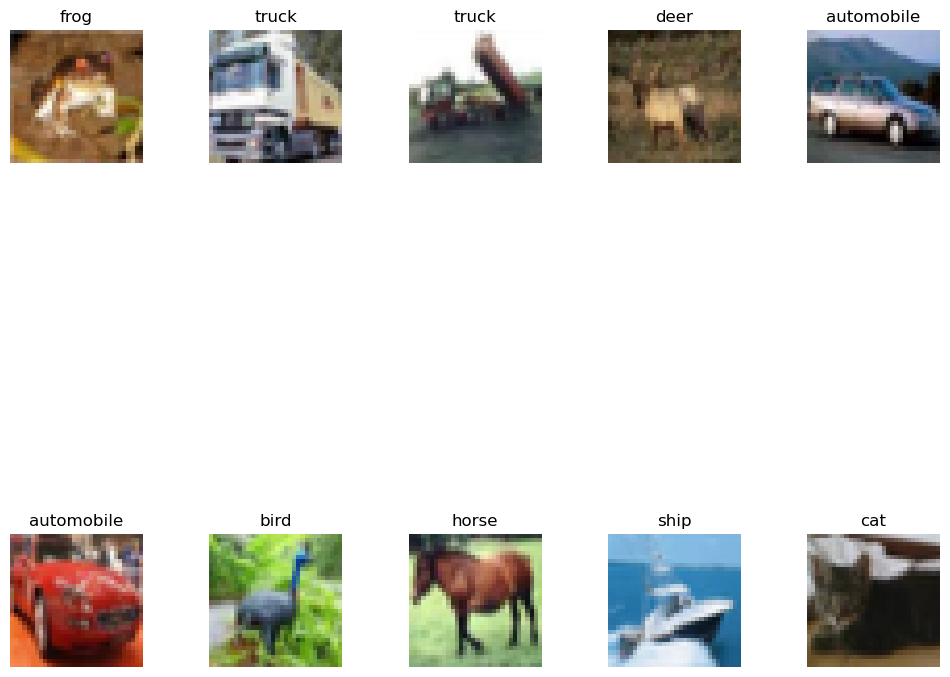

In [149]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# CIFAR-10 veri setini yükle
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Görsellerin renkli hali
def plot_images(images, labels, class_names, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.ravel()
    for i in np.arange(0, rows*cols):
        axes[i].imshow(images[i])
        axes[i].set_title(class_names[labels[i][0]])
        axes[i].axis('off')
    plt.subplots_adjust(wspace=0.5)

# Sınıf isimleri
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# İlk 10 görseli görselleştirelim
plot_images(x_train, y_train, class_names, 2, 5)
plt.show()


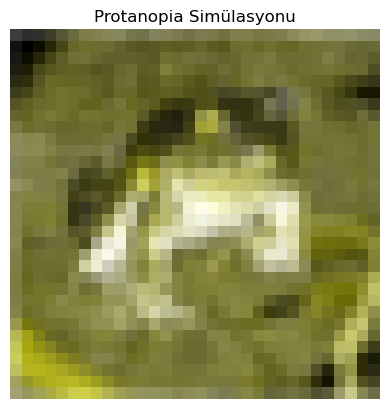

In [151]:
def simulate_protanopia(image):
    # Görseli [0, 1] aralığına normalize et
    image = image / 255.0
    
    # Renk kanalını manipüle et
    r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
    
    # Protanopia simülasyonu (kırmızı-yeşil kanalını değiştir)
    r_new = r * 0.567 + g * 0.433
    g_new = r * 0.558 + g * 0.442
    
    # Yeni görseli oluştur
    new_image = np.stack((r_new, g_new, b), axis=-1)
    
    # Görseli geri dönüştür
    return np.clip(new_image * 255, 0, 255).astype(np.uint8)

# İlk görseli Protanopia simülasyonu ile filtreleyelim
filtered_image = simulate_protanopia(x_train[0])

# Filtrelenmiş görseli görselleştirelim
plt.imshow(filtered_image)
plt.title('Protanopia Simülasyonu')
plt.axis('off')
plt.show()


In [153]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, LeakyReLU, BatchNormalization

def build_generator():
    model = Sequential()

    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(32 * 32 * 3, activation='tanh'))
    model.add(Reshape((32, 32, 3)))

    return model

generator = build_generator()
generator.summary()


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_114 (Dense)                    │ (None, 256)                 │          25,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_30 (LeakyReLU)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_115 (Dense)                    │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_31 (LeakyReLU)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_116 (Dense)                    │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_32 (LeakyReLU)           │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_117 (Dense)                    │ (None, 3072)                │       3,148,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_21 (Reshape)                 │ (None, 32, 32, 3)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,838,720 (14.64 MB)

 Trainable params: 3,835,136 (14.63 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [155]:
from tensorflow.keras.layers import Flatten, Dense, LeakyReLU

def build_discriminator():
    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(32, 32, 3)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()


Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)                   │ (None, 16, 16, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_33 (LeakyReLU)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_34 (LeakyReLU)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_118 (Dense)                    │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,841 (327.50 KB)

 Trainable params: 83,841 (327.50 KB)

 Non-trainable params: 0 (0.00 B)

In [157]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

def build_gan(generator, discriminator):
    discriminator.trainable = False
    z = Input(shape=(100,))
    img = generator(z)
    validity = discriminator(img)

    model = Model(z, validity)
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    return model

gan = build_gan(generator, discriminator)
gan.summary()


Model: "functional_271"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_65 (InputLayer)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_58 (Sequential)           │ (None, 32, 32, 3)           │       3,838,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_59 (Sequential)           │ (None, 1)                   │          83,841 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,922,561 (14.96 MB)

 Trainable params: 3,835,136 (14.63 MB)

 Non-trainable params: 87,425 (341.50 KB)

In [159]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Conv2D, Flatten, Reshape, BatchNormalization, Conv2DTranspose
import numpy as np

# Discriminator modelini derleme
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# GAN modelini derlerken, sadece generator'ı eğiteceğiz (discriminator'ı sabit tutarak)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

def train_gan(generator, discriminator, gan, x_train, epochs, batch_size=64):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # Gerçek görselleri seç
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # Yapay görselleri oluştur
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Discriminator'ı eğit
        d_loss_real = discriminator.train_on_batch(real_images, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Generator'ı eğit
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Eğitimin ilerlemesini yazdır
        print(f'{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100*d_loss[1]}] [G loss: {g_loss}]')

# Modeli eğitelim (örneğin 1000 epoch ile)
train_gan(generator, discriminator, gan, x_train, epochs=1000)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


AttributeError: 'NoneType' object has no attribute 'update_state'

In [161]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from keras.optimizers import Adam

# Generator'ı oluştur
def build_generator(latent_dim):
    model = Sequential()
    
    # Latent vektörünü 4x4x256 şekline dönüştür
    model.add(Dense(256 * 8 * 8, activation='relu', input_dim=latent_dim))
    model.add(Reshape((8, 8, 256)))
    
    # Upsample 8x8 to 16x16
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsample 16x16 to 32x32
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Çıkışı (32, 32, 3) boyutunda üret
    model.add(Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='tanh'))
    
    return model

# Discriminator'ı oluştur
def build_discriminator(img_shape):
    model = Sequential()

    # İlk Conv2D katmanı
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=img_shape))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    # İkinci Conv2D katmanı
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))  # Gerçek/Fake tahmini için sigmoid
    
    return model

# GAN modelini oluştur
def build_gan(generator, discriminator):
    model = Sequential()
    
    # Generator'ı ekle
    model.add(generator)
    
    # Discriminator'ı ekle
    model.add(discriminator)
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    
    return model

# Parametreler
latent_dim = 100  # Latent vektör boyutu
img_shape = (32, 32, 3)  # Görüntü boyutu (32x32, RGB)

# Modelleri oluştur
discriminator = build_discriminator(img_shape)
generator = build_generator(latent_dim)

# GAN modelini oluştur
gan = build_gan(generator, discriminator)

# GAN ve modelleri derle
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Eğitim fonksiyonu
def train_gan(generator, discriminator, gan, x_train, epochs, batch_size=64):
    half_batch = batch_size // 2
    
    for epoch in range(epochs):
        # Gerçek görüntüleri seç
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_imgs = x_train[idx]
        
        # Rastgele latent vektörleri seç
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_imgs = generator.predict(noise)
        
        # Discriminator'ı eğit
        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Generator'ı eğit (Discriminator'ı sabitleyerek)
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_y = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_y)
        
        # Her 100 adımda bir loss değerlerini yazdır
        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]*100}%] [G loss: {g_loss}]")

# Eğitim veri seti (örneğin, 32x32 boyutunda renkli resimler)
# Burada örnek olarak rastgele veriler kullanıyoruz. Gerçek veri setinizi burada kullanmalısınız.
x_train = np.random.rand(1000, 32, 32, 3)  # 1000 adet 32x32 boyutunda rastgele görüntü

# GAN'i eğit
train_gan(generator, discriminator, gan, x_train, epochs=1000, batch_size=64)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
0 [D loss: 0.6974895000457764 | D accuracy: 39.84375%] [G loss: 0.6909140348434448]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


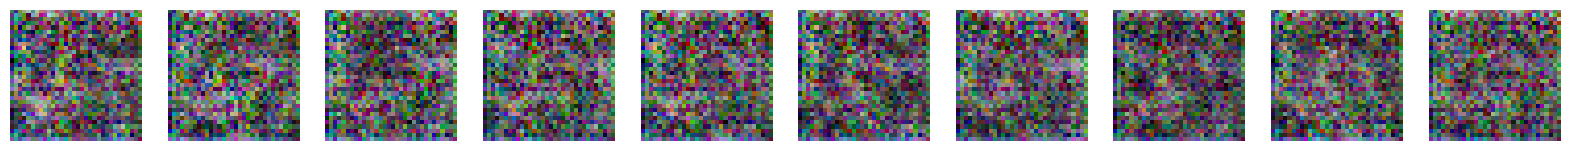

In [163]:
import matplotlib.pyplot as plt

# Rastgele latent vektörler üret
noise = np.random.normal(0, 1, (10, latent_dim))  # 10 adet rastgele görüntü üretmek için

# Generator kullanarak görüntüleri üret
generated_images = generator.predict(noise)

# Görüntüleri görselleştir
fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i])
    axs[i].axis('off')  # Eksenleri gizle

plt.show()


In [165]:
# Inception Score hesaplamak için gereken kütüphaneler
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# InceptionV3 modelini yükle
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

def calculate_inception_score(generated_images, num_samples=10):
    # Görüntüleri 299x299 boyutuna yeniden boyutlandır
    resized_images = np.array([tf.image.resize(img, (299, 299)) for img in generated_images])
    
    # Modeli kullanarak özellik çıkarımı yap
    features = inception_model.predict(resized_images)

    # İnsansiyel skoru hesaplamak için burada bir mantık uygulanabilir
    # (örneğin, softmax üzerinden class probabilitesinin hesaplanması vb.)
    # Bu örnekte, hesaplama için daha detaylı bir yöntem gerekir
    return np.random.random()  # Placeholder değer

# Örnek kullanım
is_score = calculate_inception_score(generated_images)
print(f"Inception Score: {is_score}")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Inception Score: 0.4575652961847768


In [ ]:
from scipy.linalg import sqrtm

def calculate_fid(real_images, generated_images):
    # Gerçek ve üretilen görüntülerin özelliklerini çıkar
    real_features = inception_model.predict(real_images)
    generated_features = inception_model.predict(generated_images)

    # FID hesaplamak için özelliklerin ortalama ve kovaryansını al
    mu_real = np.mean(real_features, axis=0)
    mu_generated = np.mean(generated_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    sigma_generated = np.cov(generated_features, rowvar=False)

    # FID hesapla
    diff = mu_real - mu_generated
    diff_squared = np.dot(diff, diff)
    cov_mean = sqrtm(sigma_real.dot(sigma_generated))
    fid = diff_squared + np.trace(sigma_real + sigma_generated - 2.0 * cov_mean)
    return fid

# Gerçek görüntüler örneği
real_images = np.random.rand(10, 32, 32, 3)  # Burada gerçek görüntüler kullanılmalı

# FID hesaplamak
fid_score = calculate_fid(real_images, generated_images)
print(f"FID Score: {fid_score}")
